# nested Cross-Validation

This notebook is inspired in great part by : https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0224365#pone.0224365.ref007

In [28]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold , cross_val_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb

In [29]:
## we start again by reading our data

eye_movements = pd.read_csv("../data/eye_movements_aggregated.csv")
eye_movements.head()

,titleNo,assgNo,fixcount,firstPassCnt,P1stFixation,P2stFixation,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,...,totalFixDur,meanFixDur,nRegressFrom,regressLen,nextWordRegress,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg,target
0,1,1,1.0,1.0,1.0,0.0,166.80,194.800000,194.800000,190.80,...,194.800000,194.800000,0.0,0.0,0.000000,0.0,0.053500,0.185700,0.025460,0
1,1,10,1.0,1.0,1.0,0.0,159.25,209.000000,209.000000,228.75,...,209.000000,209.000000,0.0,0.0,0.000000,0.0,-0.010225,0.049650,0.035775,0
2,1,100,1.0,1.0,1.0,0.0,139.00,165.666667,165.666667,192.00,...,165.666667,165.666667,0.0,0.0,0.333333,0.0,0.098000,0.178500,0.022467,0
3,1,101,2.0,2.0,1.0,0.0,109.50,139.000000,219.000000,109.50,...,219.000000,119.333350,0.0,0.0,0.000000,0.0,0.203750,0.554500,0.056500,0
4,1,102,1.0,1.0,1.0,0.0,109.00,114.000000,114.000000,119.00,...,114.000000,114.000000,0.0,0.0,0.000000,0.0,0.132250,0.266125,0.020350,0


In [30]:
eye_movements.shape

(2664, 25)

In [31]:
eye_features = eye_movements.loc[:,['fixcount', 'firstPassCnt', 'P1stFixation', 'P2stFixation',
       'prevFixDur', 'firstfixDur', 'firstPassFixDur', 'nextFixDur',
       'firstSaccLen', 'lastSaccLen', 'prevFixPos', 'landingPos', 'leavingPos',
       'totalFixDur', 'meanFixDur', 'nRegressFrom', 'regressLen',
       'nextWordRegress', 'regressDur', 'pupilDiamMax', 'pupilDiamLag',
       'timePrtctg']]
labels = eye_movements['target'].astype(int)

In [32]:
##let's start by splitting the data into a train and a validation set
from sklearn.model_selection import train_test_split

X, X_external, y, y_external = train_test_split(eye_features, labels, 
                                               random_state=123,
                                               train_size=1000)
y.shape , y_external.shape

((1000,), (1664,))

In [33]:
X = np.array(X) 
y = np.array(y)

In [34]:
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval


space4xgb = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1 , 200,1)),
    'eta': hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) ),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 5, 1)),
    'subsample': hp.uniform('subsample', 0.3, 1)
}

skf = StratifiedKFold(n_splits=5 , shuffle=True , random_state = 2024 )

## tentative solution
def hyperopt_xgb_train_CV5( params , X , y ):
    
    losses = -1 * cross_val_score( xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params) , 
                X , y, scoring = 'roc_auc_ovr' , cv = skf )
        
    return_dict = {'loss': np.mean(losses),
                   'loss_variance' : np.var(losses),
                   'status': STATUS_OK
                   }
    return return_dict

## simple cross-validation for tuning and evaluating

In [35]:
%%time
trials = Trials()

best = fmin(lambda params : hyperopt_xgb_train_CV5(params , X , y), 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=50, 
            trials=trials)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.32trial/s, best loss: -0.7464149074018768]
CPU times: user 3min 49s, sys: 1.11 s, total: 3min 50s
Wall time: 37.8 s


In [36]:
integer_params = ['max_depth' , 'n_estimators']
for p in integer_params:
    best[p] = int(best[p])
    
model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **best)
model.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=np.float64(0.052295099827203394),
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=65, n_jobs=6,
              num_parallel_tree=None, ...)

In [37]:
trials.best_trial['result']['loss']

-0.7464149074018768

In [38]:
def simpleCV( X ,y ):
    trials = Trials()

    best = fmin(lambda params : hyperopt_xgb_train_CV5(params , X , y), 
                space4xgb, 
                algo=tpe.suggest, 
                max_evals=20, 
                trials=trials)
    integer_params = ['max_depth' , 'n_estimators']
    for p in integer_params:
        best[p] = int(best[p])

    model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **best)
    model.fit(X,y)
    
    return model, -1 * trials.best_trial['result']['loss']


In [49]:
%%time
simpleCV( X[:100,:],y[:100] )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.41trial/s, best loss: -0.7335750497066287]
CPU times: user 37.3 s, sys: 272 ms, total: 37.6 s
Wall time: 5.98 s


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eta=np.float64(0.0248396319362649),
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=128, n_jobs=6,
               num_parallel_tree=None, ...),
 0.7335750497066287)

## tuning with CV, evaluate with test set


In [40]:
def simpleCV_with_test( X ,y , test_fraction = 0.2):
    
    X_train , X_test, y_train, y_test = train_test_split(X, y, 
                                                      stratify=y, 
                                                      test_size=test_fraction)

    model , cv_score = simpleCV( X_train ,y_train )
    test_score = roc_auc_score( y_test , model.predict_proba( X_test ) , multi_class='ovr' )
    
    return model, test_score


In [48]:
%%time
simpleCV_with_test( X[:100,:],y[:100] )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.71trial/s, best loss: -0.7266699735449735]
CPU times: user 34.7 s, sys: 240 ms, total: 35 s
Wall time: 5.57 s


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eta=np.float64(0.01641787766087851),
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=186, n_jobs=6,
               num_parallel_tree=None, ...),
 np.float64(0.8340477139819246))

## nested CV


**exercise:** implement the nested CV youself:

In [42]:
#scaffold:

def nestedCV( X ,y ):
    
    pass
    # ...
    
    return model, np.mean( test_scores )


In [51]:
# proposed solution
#%load solutions/solution_nested_cv.py


In [ ]:
%%time
nestedCV( np.array( X[:100,:] ), np.array( y[:100] )  )

To experiment with these functions, we have created a dataset fairly hard to classify, with "many" features (100), and not many training samples (100). 

As it takes a while to run all repetitions, we just plot the results here (the code to run the model training and evaluation is below).




In [53]:
df = pd.read_csv('nested_test_scores.csv')
df.head()

,score,method,nature
0,0.600990,simpleCV,reported
1,0.586990,simpleCV,reported
2,0.596081,simpleCV,reported
3,0.603636,simpleCV,reported
4,0.580717,simpleCV,reported


<Axes: xlabel='method', ylabel='score'>

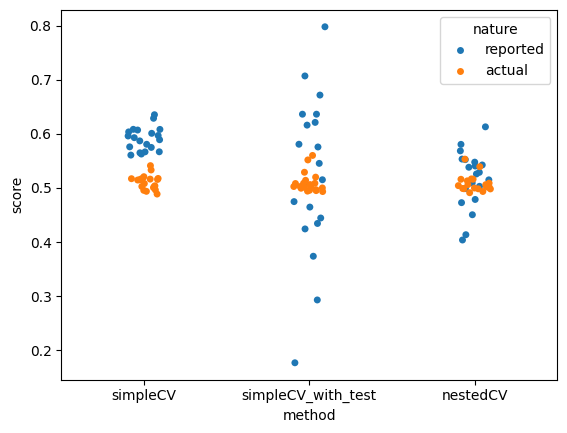

In [54]:
import seaborn as sns
sns.stripplot(df , x = 'method' , y='score' , hue='nature')

 * simple CV over-estimates its classification capabilities
 * simple CV with a test method does better but has a large variance
 * nested CV offers a more trustworthy estimate
 

In [95]:


from sklearn.datasets import make_classification

X_all, y_all = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=0.01,
    random_state=0,
)


In [96]:
X , X_external, y, y_external = train_test_split(X_all, y_all, 
                                                      stratify=y_all, 
                                                      random_state=94 , 
                                                      train_size=1000)

In [99]:
%%time 
model , score = simpleCV( X[:100,:],y[:100] )
score , roc_auc_score( y_external , model.predict_proba( X_external )[:,1] ) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89trial/s, best loss: -0.5747878787878788]
CPU times: user 1min 6s, sys: 276 ms, total: 1min 6s
Wall time: 10.9 s


(0.5747878787878788, 0.5088898772224693)

In [100]:
%%time 
model , score = simpleCV_with_test( X[:100,:],y[:100] )
score , roc_auc_score( y_external , model.predict_proba( X_external )[:,1] ) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.28trial/s, best loss: -0.7646825396825396]
CPU times: user 1min 35s, sys: 524 ms, total: 1min 35s
Wall time: 15.7 s


(0.46464646464646464, 0.5016157504039376)

In [101]:
%%time 
model , score = nestedCV( X[:100,:],y[:100] )
score , roc_auc_score( y_external , model.predict_proba( X_external )[:,1] ) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.00trial/s, best loss: -0.5751919191919191]
CPU times: user 10min, sys: 3.39 s, total: 10min 4s
Wall time: 1min 39s


(0.4604040404040404, 0.4972571243142811)

In [102]:
N = 20

In [103]:
simpleCV_reported = []
simpleCV_actual   = []

for i in range(N):
    model , score = simpleCV( X[:100,:],y[:100] )
    
    simpleCV_reported.append( score )
    simpleCV_actual.append( roc_auc_score( y_external , model.predict_proba( X_external )[:,1] )  )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.21trial/s, best loss: -0.5668686868686869]


In [104]:
simpleCV_with_test_reported = []
simpleCV_with_test_actual   = []

for i in range(N):

    model , score = simpleCV_with_test( X[:100,:],y[:100] )
    simpleCV_with_test_reported.append( score )
    simpleCV_with_test_actual.append( roc_auc_score( y_external , model.predict_proba( X_external )[:,1] ) )
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.87trial/s, best loss: -0.6004464285714286]


In [105]:
nestedCV_reported = []
nestedCV_actual   = []

for i in range(N):

    model , score = nestedCV( X[:100,:],y[:100] )
    nestedCV_reported.append(score)
    nestedCV_actual.append( roc_auc_score( y_external , model.predict_proba( X_external )[:,1] ) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.12trial/s, best loss: -0.6071924603174603]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.54trial/s, best loss: -0.6902777777777778]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.21trial/s, best loss: -0.6094141414141413]


In [106]:
df = pd.DataFrame({'score': simpleCV_reported + simpleCV_with_test_reported + nestedCV_reported + simpleCV_actual + simpleCV_with_test_actual + nestedCV_actual ,
'method' : len( simpleCV_reported) * ['simpleCV'] + len(simpleCV_with_test_reported) * ['simpleCV_with_test'] + len(nestedCV_reported) * ['nestedCV'] + len( simpleCV_actual) * ['simpleCV'] + len(simpleCV_with_test_actual) * ['simpleCV_with_test'] + len(nestedCV_actual) * ['nestedCV'],
'nature': len( simpleCV_reported + simpleCV_with_test_reported + nestedCV_reported ) * ['reported'] + len( simpleCV_actual + simpleCV_with_test_actual + nestedCV_actual) * ['actual'] } )


<Axes: xlabel='method', ylabel='score'>

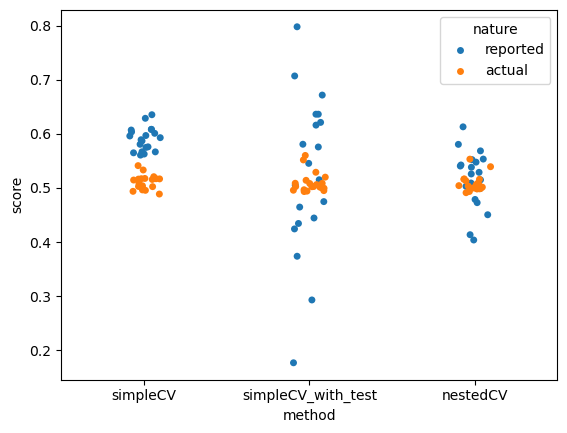

In [107]:
import seaborn as sns
sns.stripplot(df , x = 'method' , y='score' , hue='nature')

In [108]:
df.to_csv('nested_test_scores.csv', index=False)